In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
! pip install --upgrade optuna
import optuna
import xgboost
! pip install xgboost
import xgboost


In [3]:

data = pd.read_csv("/Users/erenozkan/Desktop/Data Science Project/3-16/playground-series-s3e16/train.csv")
test = pd.read_csv("/Users/erenozkan/Desktop/Data Science Project/3-16/playground-series-s3e16/test.csv")

In [4]:
data["Shucked Ratio"] = data["Weight"] / data["Shucked Weight"]
data["Shucked_log"] = np.log(data["Shucked Weight"])
data["Viscera Ratio"] = data["Weight"] / data["Viscera Weight"]
data["Viscera_log"] = np.log(data["Viscera Weight"])
data["Shell Ratio"] = data["Weight"] / data["Shell Weight"]
data["Length^2"] = data["Length"] ** 2
data["Weight_log"] = np.log(data["Weight"])
data["Length_log"] = np.log(data["Length"])
data["Volume"] = data["Length"] * data["Diameter"] * data["Height"]
data['Length_bin'] = pd.cut(data['Length'], bins=[0, 150, 180, np.inf], labels=['Small', 'Medium', 'Large'])

test["Shucked Ratio"] = test["Weight"] / test["Shucked Weight"]
test["Shucked_log"] = np.log(test["Shucked Weight"])
test["Viscera Ratio"] = test["Weight"] / test["Viscera Weight"]
test["Viscera_log"] = np.log(test["Viscera Weight"])
test["Shell Ratio"] = test["Weight"] / test["Shell Weight"]
test["Length^2"] = test["Length"] ** 2
test["Weight_log"] = np.log(test["Weight"])
test["Length_log"] = np.log(test["Length"])
test["Volume"] = test["Length"] * test["Diameter"] * test["Height"]
test['Length_bin'] = pd.cut(test['Length'], bins=[0, 150, 180, np.inf], labels=['Small', 'Medium', 'Large'])

In [5]:
le = LabelEncoder()
data["Sex"] = le.fit_transform(data["Sex"])
test["Sex"] = le.fit_transform(test["Sex"])
data['Length_bin'] = le.fit_transform(data['Length_bin'])
test['Length_bin'] = le.fit_transform(test['Length_bin'])



In [6]:
data.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age', 'Shucked Ratio', 'Shucked_log',
       'Viscera Ratio', 'Viscera_log', 'Shell Ratio', 'Length^2', 'Weight_log',
       'Length_log', 'Volume', 'Length_bin'],
      dtype='object')

In [7]:
#numerical_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight',"Shucked Ratio","Viscera Ratio","Shell Ratio","Length^2","Volume","Density"]

In [8]:
X = data.drop(["id","Age"],axis=1)
y = data["Age"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

In [11]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-06-10 02:44:59,960] A new study created in memory with name: regression
[I 2023-06-10 02:45:25,628] Trial 0 finished with value: 1.7563190724121938 and parameters: {'max_depth': 9, 'learning_rate': 0.6185636230602182, 'n_estimators': 811, 'min_child_weight': 9, 'gamma': 0.6368947842011645, 'subsample': 0.8545433245805135, 'colsample_bytree': 0.7853860946535555, 'reg_alpha': 0.09070224483436023, 'reg_lambda': 0.985193833387738, 'random_state': 741}. Best is trial 0 with value: 1.7563190724121938.
[I 2023-06-10 02:45:29,345] Trial 1 finished with value: 1.4273756911097673 and parameters: {'max_depth': 2, 'learning_rate': 0.01719713097650366, 'n_estimators': 469, 'min_child_weight': 10, 'gamma': 0.2648062113615067, 'subsample': 0.583507736464594, 'colsample_bytree': 0.7156451085744048, 'reg_alpha': 0.20969607428844073, 'reg_lambda': 0.5405548405869702, 'random_state': 394}. Best is trial 1 with value: 1.4273756911097673.
[I 2023-06-10 02:46:03,895] Trial 2 finished with value: 280

In [12]:
study.best_trial.params

{'max_depth': 8,
 'learning_rate': 0.010081456094785939,
 'n_estimators': 582,
 'min_child_weight': 3,
 'gamma': 0.10499915220768552,
 'subsample': 0.4760286930025729,
 'colsample_bytree': 0.6657230231987769,
 'reg_alpha': 0.4112372220800924,
 'reg_lambda': 0.542573259190414,
 'random_state': 683}

In [13]:
X_test_test = test.drop(["id"],axis=1)

In [14]:
best_params = study.best_trial.params
final_model = xgboost.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test_test)

In [15]:
result = pd.DataFrame({"id" : test["id"],"Age" : y_pred})

In [16]:
result.to_csv("submission.csv",index=False)

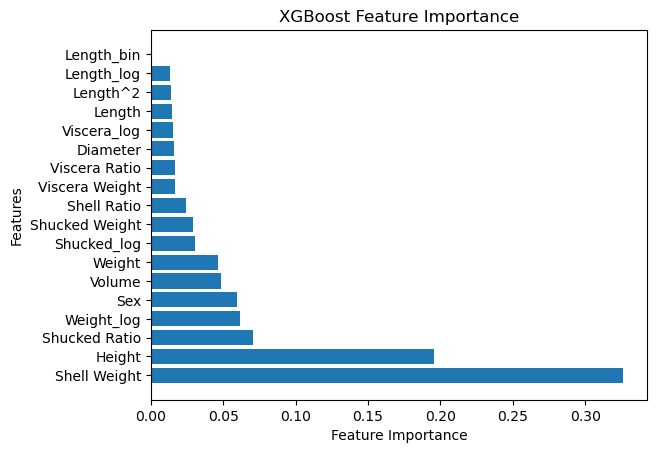

In [17]:
importance = final_model.feature_importances_
feature_names = X_train.columns

# Önem sıralamasını sıralayın
sorted_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

# Önem sıralamasını görselleştirin
features, scores = zip(*sorted_importance)
plt.barh(range(len(features)), scores, tick_label=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()






